<a href="https://colab.research.google.com/github/peekayitachi/Spam-detection/blob/main/Spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Spam Detection Program for Assignment - II

install and import important libs and load dataset

In [2]:
!pip install kagglehub imbalanced-learn nltk

# Import required libraries
import kagglehub
import pandas as pd
import numpy as np
import re
import string
import nltk
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from imblearn.over_sampling import SMOTE

# Download necessary NLTK resources
nltk.download('stopwords')
nltk.download('wordnet')

# Step 1: Download the dataset from Kaggle
path = kagglehub.dataset_download("venky73/spam-mails-dataset")
print("Path to dataset files:", path)

# Load dataset
file_path = f"{path}/spam_ham_dataset.csv"
df = pd.read_csv(file_path)

# Display dataset structure
print("Dataset Preview:")
print(df.head())

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


Path to dataset files: /root/.cache/kagglehub/datasets/venky73/spam-mails-dataset/versions/1
Dataset Preview:
   Unnamed: 0 label                                               text  \
0         605   ham  Subject: enron methanol ; meter # : 988291\r\n...   
1        2349   ham  Subject: hpl nom for january 9 , 2001\r\n( see...   
2        3624   ham  Subject: neon retreat\r\nho ho ho , we ' re ar...   
3        4685  spam  Subject: photoshop , windows , office . cheap ...   
4        2030   ham  Subject: re : indian springs\r\nthis deal is t...   

   label_num  
0          0  
1          0  
2          0  
3          1  
4          0  


##Pre-Processing

In [3]:
# Rename columns for consistency
df = df[['label', 'text']]
df.columns = ['label', 'message']

# Convert labels to binary (spam = 1, ham = 0)
df['label'] = df['label'].map({'spam': 1, 'ham': 0})

# Initialize stopwords and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Function for text cleaning, stopwords removal, and lemmatization
def preprocess_text(text):
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\W', ' ', text)  # Remove special characters
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra spaces
    words = text.split()
    words = [lemmatizer.lemmatize(word) for word in words if word not in stop_words]  # Lemmatization & stopword removal
    return ' '.join(words)

# Apply text preprocessing
df['message'] = df['message'].apply(preprocess_text)

###Code for Feature extraction
The **CountVectorizer** lib is used instead of n-grams and tf-idf which was taught in class.

In [4]:
def extract_features(text):
    features = {}
    features["text_length"] = len(text)  # Total characters
    features["num_digits"] = sum(c.isdigit() for c in text)  # Count of digits
    features["num_uppercase"] = sum(1 for c in text if c.isupper())  # Uppercase letters count
    features["num_punctuations"] = sum(1 for c in text if c in string.punctuation)  # Punctuation count
    features["num_words"] = len(text.split())  # Word count
    return features

# Apply feature extraction
feature_data = df['message'].apply(lambda x: extract_features(str(x)))

# Convert extracted features to DataFrame
X = pd.DataFrame(feature_data.tolist())
y = df['label']  # Target variable

 ## Model Training

#### Usage of SMOTE for handling class imbalance
 (Synthetic Minority Oversampling Technique, is a statistical method used in machine learning to balance datasets with an imbalance of classes)

In [5]:
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

# Train Model
model = RandomForestClassifier(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

## Model Evaluation

Model Accuracy: 0.8237

Classification Report:
              precision    recall  f1-score   support

           0       0.85      0.80      0.83       768
           1       0.80      0.85      0.82       701

    accuracy                           0.82      1469
   macro avg       0.82      0.82      0.82      1469
weighted avg       0.83      0.82      0.82      1469



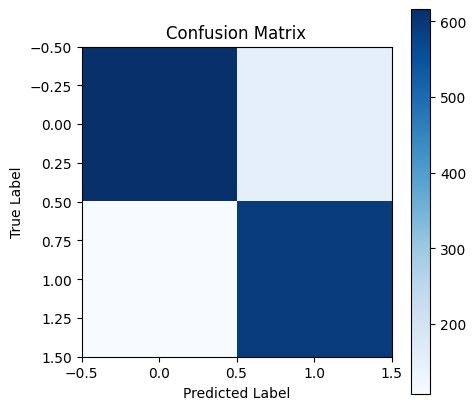

In [6]:
y_pred = model.predict(X_test)

# Print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f"Model Accuracy: {accuracy:.4f}")

# Print classification report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,5))
plt.imshow(cm, cmap='Blues', interpolation='nearest')
plt.colorbar()
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()


## Test on Custom Input

In [9]:
def predict_spam(text):
    text = preprocess_text(text)  # Apply preprocessing before prediction
    features = extract_features(text)
    text_features = pd.DataFrame([features])
    prediction = model.predict(text_features)
    return "Spam" if prediction[0] == 1 else "Not Spam"

# Example Test Case
test_message = "Congratulations! You've won a free iPhone. Click here to claim." ## enter any message here to check if spam or not
print(f"Prediction: {predict_spam(test_message)}")

Prediction: Spam


further work on project will be using OCR for text extraction from image and analysing image(screenshot) of email and analyse if spam or not